# Distance Metric Comparison
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate structure preservation of high-dimensional datasets using distance metrics other than Euclidean.__  
Tested metrics will include:
* 'chebyshev'
* 'cityblock'
* 'euclidean'
* 'seuclidean'
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
%matplotlib inline

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
First, read in retina and colon datasets with all genes present

In [3]:
# read in Macosko retina data
retina = sc.read_text('../inputs/GSM1626793_P14Retina_1.processed.tsv', delimiter='\t')
# read in Herring colon data
colon = sc.read_text('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', delimiter='\t', first_column_names=True)

In [4]:
# look at dimensions of counts matrix (cells, genes)
retina

AnnData object with n_obs × n_vars = 1326 × 500 

In [5]:
# get useful metrics of counts data
retina.var['mito'] = retina.var_names.str.contains('MT:')
sc.pp.calculate_qc_metrics(retina, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
retina.layers['raw_counts'] = retina.X.copy() # save raw counts in layer
sc.pp.normalize_total(retina, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(retina, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [6]:
# look at dimensions of counts matrix (cells, genes)
colon

AnnData object with n_obs × n_vars = 1117 × 500 

In [7]:
# get useful metrics of counts data
colon.var['mito'] = colon.var_names.str.contains('mt-')
sc.pp.calculate_qc_metrics(colon, qc_vars=['mito'], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
colon.layers['raw_counts'] = colon.X.copy() # save raw counts in layer
sc.pp.normalize_total(colon, target_sum=1, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(colon, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']

# see resulting AnnData contents
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

---
## PCA

In [9]:
retina.X = retina.layers['arcsinh_norm'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=2)
retina.obsm['pca2'] = retina.obsm['X_pca'].copy()
sc.tl.pca(retina, use_highly_variable=False, n_comps=10)
retina.obsm['pca10'] = retina.obsm['X_pca'].copy()

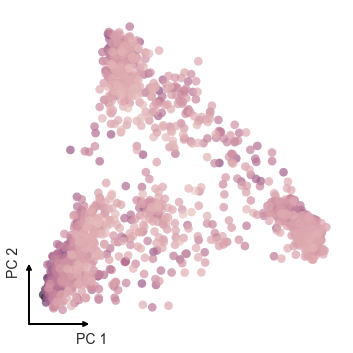

In [10]:
DR_plot(dim_name='PC').plot(retina.obsm['X_pca'], color=retina.obs['log1p_total_counts'])

Now perform same analysis on colon dataset

In [11]:
colon.X = colon.layers['arcsinh_norm'].copy()
sc.tl.pca(colon, use_highly_variable=False, n_comps=2)
colon.obsm['pca2'] = colon.obsm['X_pca'].copy()
sc.tl.pca(colon, use_highly_variable=False, n_comps=10)
colon.obsm['pca10'] = colon.obsm['X_pca'].copy()

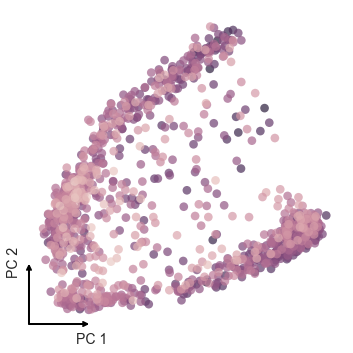

In [12]:
DR_plot(dim_name='PC').plot(colon.obsm['X_pca'], color=colon.obs['log1p_total_counts'])

---
## Read in other dimension-reduced spaces for each dataset

In [13]:
retina.obsm['tsne'] = np.genfromtxt('outputs/retina_tSNE.csv', delimiter=',')
retina.obsm['umap'] = np.genfromtxt('outputs/retina_UMAP.csv', delimiter=',')
retina.obsm['fitsne'] = np.genfromtxt('outputs/retina_FItSNE.csv', delimiter=',')
retina.obsm['dca'] = np.genfromtxt('outputs/retina_DCA.csv', delimiter=',')
retina.obsm['glmpca'] = np.genfromtxt('outputs/retina_GLM-PCA.csv', delimiter=',', skip_header=1)
retina.obsm['scvi'] = np.genfromtxt('outputs/retina_scVI.csv', delimiter=',')
retina.obsm['simlr'] = np.genfromtxt('outputs/retina_SIMLR_F.csv', delimiter=',', skip_header=1)
retina.obsm['zifa'] = np.genfromtxt('outputs/retina_ZIFA.csv', delimiter=',')
retina.obsm['zinbwave'] = np.genfromtxt('outputs/retina_ZINB-WAVE.csv', delimiter=',', skip_header=1)
retina.obsm['scvis'] = np.genfromtxt('scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', 
                                     delimiter='\t', skip_header=1, usecols=(1,2))

In [14]:
retina

AnnData object with n_obs × n_vars = 1326 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'pca2', 'pca10', 'tsne', 'umap', 'fitsne', 'dca', 'glmpca', 'scvi', 'simlr', 'zifa', 'zinbwave', 'scvis'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm'

In [15]:
colon.obsm['tsne'] = np.genfromtxt('outputs/colon_tSNE.csv', delimiter=',')
colon.obsm['umap'] = np.genfromtxt('outputs/colon_UMAP.csv', delimiter=',')
colon.obsm['fitsne'] = np.genfromtxt('outputs/colon_FItSNE.csv', delimiter=',')
colon.obsm['dca'] = np.genfromtxt('outputs/colon_DCA.csv', delimiter=',')
colon.obsm['glmpca'] = np.genfromtxt('outputs/colon_GLM-PCA.csv', delimiter=',', skip_header=1)
colon.obsm['scvi'] = np.genfromtxt('outputs/colon_scVI.csv', delimiter=',')
colon.obsm['simlr'] = np.genfromtxt('outputs/colon_SIMLR_F.csv', delimiter=',', skip_header=1)
colon.obsm['zifa'] = np.genfromtxt('outputs/colon_ZIFA.csv', delimiter=',')
colon.obsm['zinbwave'] = np.genfromtxt('outputs/colon_ZINB-WAVE.csv', delimiter=',', skip_header=1)
colon.obsm['scvis'] = np.genfromtxt('scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', 
                                     delimiter='\t', skip_header=1, usecols=(1,2))

In [16]:
colon

AnnData object with n_obs × n_vars = 1117 × 500 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'pca2', 'pca10', 'tsne', 'umap', 'fitsne', 'dca', 'glmpca', 'scvi', 'simlr', 'zifa', 'zinbwave', 'scvis'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm'

---

In [17]:
# choose value for K-nearest neighbor calculations. 
# We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [18]:
stats = {
    'retina':{
        'R':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        },
        'EMD':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        },
        'Knn Pres.':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        }
    },
    'colon':{
        'R':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        },
        'EMD':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        },
        'Knn Pres.':{
            'pca2':{},'tsne':{},'umap':{},'fitsne':{},'dca':{},'glmpca':{},'scvi':{},'simlr':{},'zifa':{},'zinbwave':{},'pca10':{},'scvis':{}
        }
    }
}

In [19]:
drs = ['pca2','tsne','umap','fitsne','dca','glmpca','scvi','simlr','zifa','zinbwave','pca10','scvis']
metrics = ['chebyshev','cityblock','euclidean','seuclidean']

In [20]:
%%time 
for metric in metrics:
    for dr in drs:
        print('Processing {} with distance metric = {}'.format(dr, metric))
        corr, EMD, knnP = structure_preservation_sc(retina, latent=dr, native='X', metric=metric, k=k, force_recalc=True, verbose=False)
        stats['retina']['R'][dr][metric], stats['retina']['EMD'][dr][metric], stats['retina']['Knn Pres.'][dr][metric] = corr[0], EMD, knnP

Processing pca2 with distance metric = chebyshev
Processing tsne with distance metric = chebyshev
Processing umap with distance metric = chebyshev
Processing fitsne with distance metric = chebyshev
Processing dca with distance metric = chebyshev
Processing glmpca with distance metric = chebyshev
Processing scvi with distance metric = chebyshev
Processing simlr with distance metric = chebyshev
Processing zifa with distance metric = chebyshev
Processing zinbwave with distance metric = chebyshev
Processing pca10 with distance metric = chebyshev
Processing scvis with distance metric = chebyshev
Processing pca2 with distance metric = cityblock
Processing tsne with distance metric = cityblock
Processing umap with distance metric = cityblock
Processing fitsne with distance metric = cityblock
Processing dca with distance metric = cityblock
Processing glmpca with distance metric = cityblock
Processing scvi with distance metric = cityblock
Processing simlr with distance metric = cityblock
Proces

In [21]:
%%time 
for metric in metrics:
    for dr in drs:
        print('Processing {} with distance metric = {}'.format(dr, metric))
        corr, EMD, knnP = structure_preservation_sc(colon, latent=dr, native='X', metric=metric, k=k, force_recalc=True, verbose=False)
        stats['colon']['R'][dr][metric], stats['colon']['EMD'][dr][metric], stats['colon']['Knn Pres.'][dr][metric] = corr[0], EMD, knnP

Processing pca2 with distance metric = chebyshev
Processing tsne with distance metric = chebyshev
Processing umap with distance metric = chebyshev
Processing fitsne with distance metric = chebyshev
Processing dca with distance metric = chebyshev
Processing glmpca with distance metric = chebyshev
Processing scvi with distance metric = chebyshev
Processing simlr with distance metric = chebyshev
Processing zifa with distance metric = chebyshev
Processing zinbwave with distance metric = chebyshev
Processing pca10 with distance metric = chebyshev
Processing scvis with distance metric = chebyshev
Processing pca2 with distance metric = cityblock
Processing tsne with distance metric = cityblock
Processing umap with distance metric = cityblock
Processing fitsne with distance metric = cityblock
Processing dca with distance metric = cityblock
Processing glmpca with distance metric = cityblock
Processing scvi with distance metric = cityblock
Processing simlr with distance metric = cityblock
Proces

---
### Summary Metrics

In [22]:
retina_R = pd.DataFrame(stats['retina']['R'])
retina_EMD = pd.DataFrame(stats['retina']['EMD'])

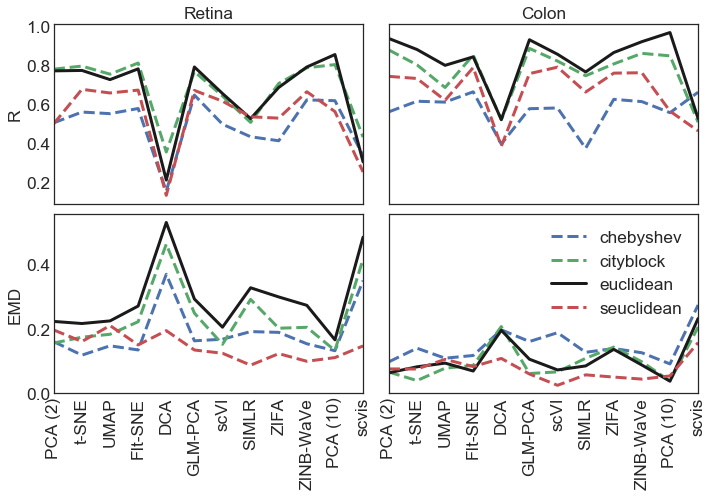

In [46]:
styles = ['b--', 'g--', 'k-', 'r--']

with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex='col', sharey='row')
    retina_R.T.plot(ax=axes[0,0], linewidth=3, style=styles, legend=False)
    axes[0,0].set_ylabel('R', fontsize='xx-large')
    axes[0,0].tick_params(axis='both', which='major', labelsize='xx-large')
    axes[0,0].set_title('Retina', fontsize='xx-large')
    colon_R.T.plot(ax=axes[0,1], linewidth=3, style=styles, legend=False)
    axes[0,1].tick_params(axis='both', which='major', labelsize='xx-large')
    axes[0,1].set_title('Colon', fontsize='xx-large')
    retina_EMD.T.plot(ax=axes[1,0], linewidth=3, style=styles, legend=False)
    axes[1,0].set_ylabel('EMD', fontsize='xx-large')
    axes[1,0].tick_params(axis='both', which='major', labelsize='xx-large')
    axes[1,0].set_xticks(np.arange(0,12))
    axes[1,0].set_xticklabels(['PCA (2)','t-SNE','UMAP','FIt-SNE','DCA','GLM-PCA','scVI','SIMLR','ZIFA','ZINB-WaVe','PCA (10)','scvis'], fontsize='xx-large', rotation=90)
    colon_EMD.T.plot(ax=axes[1,1], linewidth=3, style=styles)
    axes[1,1].tick_params(axis='both', which='major', labelsize='xx-large')
    axes[1,1].set_xticks(np.arange(0,12))
    axes[1,1].set_xticklabels(['PCA (2)','t-SNE','UMAP','FIt-SNE','DCA','GLM-PCA','scVI','SIMLR','ZIFA','ZINB-WaVe','PCA (10)','scvis'], fontsize='xx-large', rotation=90)
    axes[1,1].legend(fontsize='xx-large')
    plt.tight_layout()
    plt.savefig('outputs/distance_metric_comparison.png', dpi=1000)